In [103]:
################ 导入相关包 #####################
import os
import sys
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from statistics import mean
from nltk.metrics import scores
from hpv import train, detect, NucleusDataset, NucleusConfig, NucleusInferenceConfig

In [84]:
ROOT_DIR = os.path.abspath("../../")
print(ROOT_DIR)
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
import mrcnn.model as modellib
import hpv
import pickle

/home/hqyone/mnt/2tb/github/cancer_rcnn


In [97]:
##############  Parameter Settings  ####
LOGS_DIR = os.path.join(ROOT_DIR, "logs")
DATASET_DIR = os.path.join(ROOT_DIR, "data/stage1_test")   #  数据集
config = hpv.NucleusInferenceConfig()
DEVICE = "/cpu:0"
TEST_MODE = "inference"
def get_ax(rows=1, cols=1, size=16):
    fig, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    fig.tight_layout()
    return ax
def text_save(filename, data):#filename为写入CSV文件的路径，data为要写入数据列表.
    file = open(filename, 'a')
    for i in range(len(data)):
        s = str(data[i]).replace('[','').replace(']','')#去除[],这两行按数据不同，可以选择
        s = s.replace("'",'').replace(',','') +'\n'   #去除单引号，逗号，每行末尾追加换行符
        file.write(s)
    file.close()
    print("保存txt文件成功")

In [104]:
def getMeanAP(model, DATASET_DIR, image_ls, do_plot=False):
    dataset = hpv.NucleusDataset()
    dataset.load_nucleus(DATASET_DIR, image_ls)
    dataset.prepare()
    print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))
    count1 = 0
    AP_ls=[]
    for image_id in dataset.image_ids:
        info = dataset.image_info[image_id]
        print("image_id: ", info)
        # ####重要步骤：获得测试图片的信息
        image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
        # ###保存实际结果
        if count1 == 0:
            gt_bbox_all, gt_class_id_all, gt_mask_all = gt_bbox, gt_class_id, gt_mask
        else:
            gt_bbox_all = np.concatenate((gt_bbox_all, gt_bbox), axis=0)
            gt_class_id_all = np.concatenate((gt_class_id_all, gt_class_id), axis=0)
            gt_mask_all = np.concatenate((gt_mask_all, gt_mask), axis=2)
        # # 显示检测结果
        results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)
        r = results[0]
        # 保存预测结果
        if count1 == 0:
            pre_masks_all, pre_class_ids_all, pre_rois_all, pre_scores_all = r['masks'], r["class_ids"], r["rois"], r["scores"]
        else:
            pre_masks_all = np.concatenate((pre_masks_all, r['masks']), axis=2)
            pre_class_ids_all = np.concatenate((pre_class_ids_all, r['class_ids']), axis=0)
            pre_rois_all = np.concatenate((pre_rois_all, r['rois']), axis=0)
            pre_scores_all = np.concatenate((pre_scores_all, r['scores']), axis=0)
        count1 += 1
        AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox_all, gt_class_id_all, gt_mask_all,
                                                     pre_rois_all, pre_class_ids_all, pre_scores_all, pre_masks_all)
        if (do_plot):
            print("precisions: ", precisions)
            print("AP: ", AP)

            plt.figure("P-R Curve")
            plt.title('Precision-Recall Curve. AP@50 = {:.3f}'.format(AP))
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.plot(recalls, precisions, 'b', label='PR')
            plt.show()
            text_save('Kpreci.txt', precisions)
            text_save('Krecall.txt', recalls)
        AP_ls.append(AP)
    return mean(AP_ls)

def getSelectedImageList(DATASET_DIR,ext=".png",batch_size=3):
    sel_image_ls = []
    directories = os.listdir(DATASET_DIR)
    validated_directory_ls = []
    for directory in directories:
        img_file = os.path.join(DATASET_DIR,directory,directory+ext)
        #print(img_file)
        if os.path.isfile(img_file):
            validated_directory_ls.append(directory)
    if batch_size<len(validated_directory_ls):
        sel_image_ls = random.choices(validated_directory_ls, k=batch_size)
    return (sel_image_ls)

def getCrossValidateMeanAP(model, sel_image_ls, do_plot=False):
    mean_AP = getMeanAP(model, DATASET_DIR, sel_image_ls, do_plot=do_plot)
    return (mean_AP)

def RunCrossValidation(weights_path_ls, DATASET_DIR,batch_size=3, folds=2, do_plot=False):
    config = NucleusInferenceConfig()
    with tf.device(DEVICE):
        for i in range(folds):
            sel_image_ls = getSelectedImageList(DATASET_DIR,ext=".png",batch_size=batch_size)
            print(sel_image_ls)
            meanAP_ls=[]
            for weights_path in weights_path_ls:
                model = modellib.MaskRCNN(mode="inference",model_dir=LOGS_DIR,config=config)
                model.load_weights(weights_path, by_name=True)
                meanAP = getCrossValidateMeanAP(model, sel_image_ls, do_plot=do_plot)
                meanAP_ls.append(meanAP)
            print(meanAP_ls)

weights_path_ls=["/home/hqyone/mnt/2tb/github/cancer_rcnn/code/cell_classification/model/mask_rcnn_modelA3-4_0150.h5", "/home/hqyone/mnt/2tb/github/cancer_rcnn/code/cell_classification/model/mask_rcnn_modelT1-1_0300.h5"]



In [105]:
RunCrossValidation(weights_path_ls, DATASET_DIR,batch_size=3, folds=3, do_plot=False)

['1480', '1481', '1478']
Images: 3
Classes: ['BG', 'yin', 'yin-yang', 'yang']
image_id:  {'id': '1480', 'source': 'nucleus', 'path': '/home/hqyone/mnt/2tb/github/cancer_rcnn/data/stage1_test/1480/1480.png'}
/home/hqyone/mnt/2tb/github/cancer_rcnn/data/stage1_test/1480/masksxxxxx
Processing 1 images
image                    shape: (2048, 2048, 3)       min:   26.00000  max:  253.00000  uint8
molded_images            shape: (1, 2048, 2048, 3)    min:   26.00000  max:  253.00000  uint8
image_metas              shape: (1, 16)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 1047552, 4)       min:   -0.04422  max:    1.01295  float32
image_id:  {'id': '1481', 'source': 'nucleus', 'path': '/home/hqyone/mnt/2tb/github/cancer_rcnn/data/stage1_test/1481/1481.png'}
/home/hqyone/mnt/2tb/github/cancer_rcnn/data/stage1_test/1481/masksxxxxx
Processing 1 images
image                    shape: (2048, 2048, 3)       min:    9.00000  max:  243.00000  uint8
mold

In [90]:
for i in range(2):
    print(i)

0
1


In [77]:
ext=".png"
directories = os.listdir(DATASET_DIR)
validated_directory_ls = []
for directory in directories:
    img_file = os.path.join(DATASET_DIR,directory,directory+ext)
    #print(img_file)
    if os.path.isfile(img_file):
        validated_directory_ls.append(directory)
print(random.choices(validated_directory_ls, k=10))


['xx_best_135_23_20', 'xx_best_183_20_19_2', 'xx_best_185_22_19', 'xx_best_1751_34_5', 'xx_best_51_22_27_3', 'xx_best_292_17_31_2', 'xx_best_334_35_27', 'xx_best_250_28_18', 'xx_best_45_26_29', 'xx_best_292_17_31']


In [78]:
#####  加载测试集数据  #####
dataset = hpv.NucleusDataset()
print(DATASET_DIR)
image_ls=["1456","1458","1462","1478","1479","1480","1481","1486"]
image_ls=["1456","1458","1462"]
# dataset.load_nucleus(DATASET_DIR, "stage1_test")
dataset.load_nucleus(DATASET_DIR, image_ls)
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

#####  导入模型  ####
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",model_dir=LOGS_DIR,config=config)
weights_path = "/home/hqyone/mnt/2tb/github/cancer_rcnn/code/cell_classification/model/mask_rcnn_modelA3-4_0150.h5"
# weights_path = "/Mask_RCNN/logs/nucleus20210105T1517/mask_rcnn_nucleus_0285.h5"
model.load_weights(weights_path, by_name=True)
# image_id = random.choice(dataset.image_ids)   # 随机选取一张测试集
image_ids = dataset.image_ids
print(dataset.image_ids)

/home/hqyone/mnt/2tb/github/cancer_rcnn/data/cc_tct_labeled_500_v1
Images: 3
Classes: ['BG', 'yin', 'yin-yang', 'yang']
[0 1 2]


image_id:  0
/home/hqyone/mnt/2tb/github/cancer_rcnn/data/cc_tct_labeled_500_v1/1456/masksxxxxx
Processing 1 images
image                    shape: (2048, 2048, 3)       min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 2048, 2048, 3)    min:   19.00000  max:  255.00000  uint8
image_metas              shape: (1, 16)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 1047552, 4)       min:   -0.04422  max:    1.01295  float32
image_id:  1
/home/hqyone/mnt/2tb/github/cancer_rcnn/data/cc_tct_labeled_500_v1/1458/masksxxxxx
Processing 1 images
image                    shape: (2048, 2048, 3)       min:   21.00000  max:  249.00000  uint8
molded_images            shape: (1, 2048, 2048, 3)    min:   21.00000  max:  249.00000  uint8
image_metas              shape: (1, 16)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 1047552, 4)       min:   -0.04422  max:    1.01295  float32
image_id

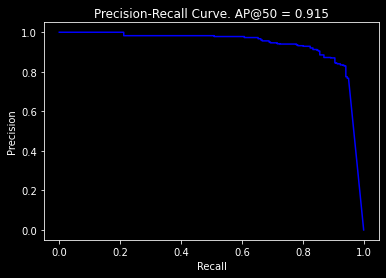

保存txt文件成功
保存txt文件成功


In [79]:
APs = []
count1 = 0
for image_id in image_ids:
    info = dataset.image_info[image_id]
    print("image_id: ", image_id)
    # ####重要步骤：获得测试图片的信息
    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    # ###保存实际结果
    if count1 == 0:
        gt_bbox_all, gt_class_id_all, gt_mask_all = gt_bbox, gt_class_id, gt_mask
    else:
        gt_bbox_all = np.concatenate((gt_bbox_all, gt_bbox), axis=0)
        gt_class_id_all = np.concatenate((gt_class_id_all, gt_class_id), axis=0)
        gt_mask_all = np.concatenate((gt_mask_all, gt_mask), axis=2)
    # # 显示检测结果
    results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)
    r = results[0]
    # 保存预测结果
    if count1 == 0:
        pre_masks_all, pre_class_ids_all, pre_rois_all, pre_scores_all = r['masks'], r["class_ids"], r["rois"], r["scores"]
    else:
        pre_masks_all = np.concatenate((pre_masks_all, r['masks']), axis=2)
        pre_class_ids_all = np.concatenate((pre_class_ids_all, r['class_ids']), axis=0)
        pre_rois_all = np.concatenate((pre_rois_all, r['rois']), axis=0)
        pre_scores_all = np.concatenate((pre_scores_all, r['scores']), axis=0)

    count1 += 1


# # 在阈值0.5到0.95之间每隔0.1显示AP值
# utils.compute_ap_range(gt_bbox_all, gt_class_id_all, gt_mask_all, pre_rois_all, pre_class_ids_all, pre_scores_all, pre_masks_all, verbose=1)
## 在图片中显示真实与预测之间的差异
# visualize.display_differences(image, gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'],
#                               dataset.class_names, ax=get_ax(), show_box=False, show_mask=False, iou_threshold=0.5, score_threshold=0.5)
# plt.show()

# ######绘制PR曲线######
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox_all, gt_class_id_all, gt_mask_all,
                                                     pre_rois_all, pre_class_ids_all, pre_scores_all, pre_masks_all)
print("precisions: ", precisions)
print("AP: ", AP)

plt.figure("P-R Curve")
plt.title('Precision-Recall Curve. AP@50 = {:.3f}'.format(AP))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recalls, precisions, 'b', label='PR')
plt.show()
text_save('Kpreci.txt', precisions)
text_save('Krecall.txt', recalls)